In [1]:
%load_ext autotime

In [8]:
# time: 1.16 s

import pickle
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from lib.Text_Pre_Processing_in_Python import Preprocess
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')

%matplotlib inline
# warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# time: 235 µs

vectorizer_max_features = 1500

In [2]:
# time: 6.5 s

all_text = pd.read_csv('archive/sub_reddits.all.csv', low_memory=False)
all_text['selftext'] = all_text['selftext'].astype(str)

In [ ]:
# time: 22min 24s

prep = Preprocess.Preprocess()
sanitized_posts = []

for post in all_text['selftext']:
    document = re.sub(r'https*:\/\/[\w*\-*\.]*[\w\-*\/]*[\.\w]*[^\"\s]*', ' ', str(post))
    document = re.sub(r'\/[\w*\-*\.]*[\w\-*\/]*[\.\w]*[^\"\s]*', ' ', document)
    document = re.sub(r'amp;', '', document)
    document = " ".join(prep.preprocess(document))
    sanitized_posts.append(document)


In [ ]:
# time: 191 ms

with open('archive/pre_processed.all.pkl', 'wb') as picklefile:
    pickle.dump(sanitized_posts, picklefile)

In [9]:
# time: 238 ms

with open('archive/pre_processed.all.pkl', 'rb') as picklefile:
    sanitized_posts_df = pd.DataFrame(pickle.load(picklefile), columns=["posts"])

In [10]:
# time: 2min 13s

sanitized_posts_df = sanitized_posts_df[sanitized_posts_df['posts'] != 'test']
sanitized_posts_df = sanitized_posts_df[sanitized_posts_df['posts'] != '']
sanitized_posts_df = sanitized_posts_df[sanitized_posts_df['posts'] != 'a']
sanitized_posts_df = sanitized_posts_df[sanitized_posts_df['posts'] != '_']
sanitized_posts_df = sanitized_posts_df[sanitized_posts_df['posts'] != ' ']
sanitized_posts_df = sanitized_posts_df[sanitized_posts_df['posts'].str.contains('[^\d^\s]')]
sanitized_posts_df['posts'] = sanitized_posts_df['posts'].astype(str)

sanitized_posts_df.to_csv('archive/sanitized.all.csv', index=False)

In [ ]:
# time: 703 µs

# Workspace for additional text cleaning

In [ ]:
# time: 1.53 s

sanitized_posts_df = pd.read_csv('archive/sanitized.csv')

# Corex

In [6]:
# time: 561 ms

import scipy.sparse as ss

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

In [11]:
# time: 17.5 s

cor_vectorizer = CountVectorizer(max_features=20000, stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", binary=True)

cor_posts = cor_vectorizer.fit_transform(sanitized_posts_df['posts'])
cor_words = list(np.asarray(cor_vectorizer.get_feature_names()))

In [12]:
# time: 51.3 s

topic_model = ct.Corex(n_hidden=20, words=cor_words, seed=1)
topic_model.fit(cor_posts, words=cor_words, docs=sanitized_posts_df['posts'])

In [ ]:
# time: 19.8 ms

topics = topic_model.get_topics()
for n, topic in enumerate(topics):
    topic_words, _ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

In [ ]:
# time: 227 ms

topic_model.get_top_docs(topic=4, n_docs=2)

In [ ]:
# time: 372 ms

predictions = pd.DataFrame(topic_model.predict(cor_posts), columns=['topic'+str(i) for i in range(20)])
predictions.head(3)

In [ ]:
# time: 208 ms

plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [ ]:
def get_topic_words( anchor_word_list, cor_words, ct, cor_posts, sanitized_posts_df, n_hidden=20):
    topic_list = []

    topic_model = ct.Corex(n_hidden=n_hidden, words=cor_words,
                       max_iter=200, verbose=False, seed=1)

    topic_model.fit(cor_posts, words=cor_words, docs=sanitized_posts_df['posts'], 
                    anchors=anchor_word_list, anchor_strength=2)

    # Print all topics from the CorEx topic model
    topics = topic_model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        topic_list.append('{}: '.format(n) + ', '.join(topic_words))

    return topic_list

In [ ]:
# time: 1min 40s
n_hidden = 20
anchor_word_list = [['options'], ['tendies'], ['yolo'], ['fomo'], ['stock'], ['stonk'], ['etf'], ['bond'], ['trump'], ['hillary'], ['god'], ['politics']]

for topic in get_topic_words(anchor_word_list, cor_words, ct, cor_posts, sanitized_posts_df):
    print(topic)

In [ ]:
n_hidden = 40
anchor_word_list = [['options'], ['tendies'], ['yolo'], ['fomo'], ['stock'], ['stonk'], ['etf'], ['bond'], ['trump'], ['hillary'], ['god'], ['politics']]

for topic in get_topic_words(anchor_word_list, cor_words, ct, cor_posts, sanitized_posts_df, n_hidden):
    print(topic)

In [ ]:
anchor_word_list = [['aapl'], ['tsla'], ['amzn'], ['spy'], ['qqq'], ['bynd'], ['nio'], ['nkla']]

for topic in get_topic_words(anchor_word_list, cor_words, ct, cor_posts, sanitized_posts_df):
    print(topic)

In [ ]:
# time: 9.72 s

for i in range(n_hidden):
    print(topic_model.get_top_docs(topic=i, n_docs=2))

In [ ]:
# time: 10.2 s

vt.vis_rep(topic_model, column_label=cor_words, prefix='topic-model-example')

In [8]:
# time: 1min 21s

# Train a second layer to the topic model
tm_layer2 = ct.Corex(n_hidden=10)
tm_layer2.fit(topic_model.labels);

# Train a third layer to the topic model
tm_layer3 = ct.Corex(n_hidden=1)
tm_layer3.fit(tm_layer2.labels);



In [9]:
vt.vis_hierarchy([topic_model, tm_layer2, tm_layer3], column_label=cor_words, max_edges=200, prefix='topic-model')

weight threshold is 0.000000 for graph with max of 200.000000 edges 
non-isolated nodes,edges 25 24
non-isolated nodes,edges 25 24


In [14]:
topic_model.tc_history

[0.019657411383445227,
 15.24027455403997,
 110.87460485138547,
 48.356588589338024,
 33.87234515111618,
 20.14252210869497,
 27.50431972935497,
 16.08017411272709,
 24.998825360370457,
 15.18411728024305,
 18.74938858018774,
 14.943654400753491,
 15.706518863031121,
 15.00293854979128,
 15.241017428336066,
 15.145879865207242,
 15.16792626832623,
 15.154303531801881,
 15.170787564846602,
 15.166968066687051,
 15.180128182962068,
 15.18359773027722,
 15.184711905184981,
 15.181379170283654,
 15.179688729392238,
 15.179501474335423,
 15.178535369269634,
 15.17754566276566,
 15.177279809203124,
 15.177255025176859,
 15.176969239601284,
 15.176579065819407,
 15.17633389221455,
 15.17634929119374,
 15.176203544408908,
 15.176484199976944,
 15.176560914910743,
 15.17648718607776,
 15.176236811718882,
 15.176386707696468,
 15.17636677860926,
 15.176421879371837]

In [ ]:
# time: 6.01 ms

topic_model_labels_df = pd.DataFrame(topic_model.labels)

In [ ]:
topic_model.p_y_given_x[:5]

df = df.join(pd.DataFrame(topic_model_anc.p_y_given_x[:5], columns = topics)) (topic_model_anc.p_y_given_x)

In [ ]:
topic_model_y_given_x_df = pd.DataFrame(topic_model.p_y_given_x, columns=topic_model.get_topics())

# KMeans

In [ ]:
# time: 75.8 ms

from sklearn.cluster import KMeans

# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X, km=[], num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], c=color[0], alpha=alpha, s=s)
        
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [ ]:
# time: 6.11 s

num_clusters = 7
km = KMeans(n_clusters=num_clusters, n_init=10, max_iter=300, random_state=42)
km.fit(topic_model_y_given_x_df)

In [ ]:
# time: 366 µs

km_labels = km.labels_

In [ ]:
# time: 35.6 s

inertias = []

for k_ in np.arange(1, 10):
    km = KMeans(n_clusters=k_)
    km.fit(topic_model_labels_df)
    inertias.append(km.inertia_)

In [ ]:
# time: 386 ms

plt.plot(np.arange(1, 10), inertias, marker='o')
plt.vlines(x=3, ymin=0, ymax=max(inertias), ls='--', label='Elbow')
plt.ylabel("Inertia")
plt.xlabel('k')
plt.legend()

In [ ]:
# time: 2.61 s

num_clusters = 4
km = KMeans(n_clusters=num_clusters, n_init=10, max_iter=300, random_state=42)
km.fit(topic_model_labels_df)

In [ ]:
km.

# PCA

In [ ]:
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm

In [ ]:
# Take all of the data and plot it on 2 dimensions
pca = PCA(n_components=2)

In [ ]:
cvp_arr = count_vectorized_posts.toarray()
cvp_df = pd.DataFrame(cvp_arr)
cvp_df.head()

In [ ]:
# time: 17min 45s - 150,000 wsb entries
# crashes
pca.fit(cvp_df)
pcafeatures_train = pca.transform(cvp_df)

In [ ]:
with open('archive/pca.pkl', 'wb') as picklefile:
    pickle.dump(pca, picklefile)

In [ ]:
# create a plot of the PCA results
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r', 'g', 'b', 'c' , 'm', 'y', 'orange', 'w', 'aqua', 'yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10, 10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1], c=c, label=label, edgecolors='gray')
    plt.legend()

In [ ]:
# plot of all the numbers
plot_PCA_2D(pcafeatures_train, target=, target_names=digits.target_names)

# KMeans

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [ ]:
# helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X, km=[], num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    
    if num_clusters == 0:
        plt.scatter(X[:,0], X[:,1], c=color[0], alpha=alpha, s=s)
        
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [ ]:
# time: 38.9 s

random_state = 0 

vec = TfidfVectorizer(stop_words="english")
vec.fit(all_text.selftext.values)
features = vec.transform(all_text.selftext.values)

In [ ]:
# time: 16 s

cls = MiniBatchKMeans(n_clusters=5, random_state=random_state)
cls.fit(features)

In [ ]:
# time: 5.88 s

# predict cluster labels for new dataset
cls.predict(features)

# to get cluster labels for the dataset used while
# training the model (used for models that does not
# support prediction on new dataset).
cls.labels_

In [ ]:
# time: 390 µs

# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)

In [ ]:
reduced_features_pca = pca.fit(features.toarray())


In [ ]:
reduced_features = pca.transform(reduced_features_pca.toarray())


In [ ]:
# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

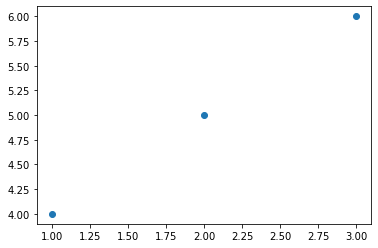

In [3]:
plt.scatter([1,2,3], [4,5,6])